Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
from scipy.fftpack import fft
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
import warnings
%matplotlib inline

Read training data and manage NaN values by filling them with 0, then show the head

In [2]:
train = pd.read_csv("data/train_1.csv").fillna(0)
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


Cast every value to an integer number to save memory, floats take up more space

In [3]:
for col in train.columns[1:]:
    train[col] = pd.to_numeric(train[col], downcast="integer")
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,9,22,26,...,32,63,15,26,14,20,22,19,18,20
1,2PM_zh.wikipedia.org_all-access_spider,11,14,15,18,11,13,22,11,10,...,17,42,28,15,9,30,52,45,26,20
2,3C_zh.wikipedia.org_all-access_spider,1,0,1,1,0,4,0,3,4,...,3,1,1,7,4,4,6,3,4,17
3,4minute_zh.wikipedia.org_all-access_spider,35,13,10,94,4,26,14,9,11,...,32,10,26,27,16,11,17,19,10,11
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0,0,0,0,0,0,0,0,0,...,48,9,25,13,3,11,27,13,36,10


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: int32(550), object(1)
memory usage: 305.5+ MB


Is traffic influenced by page language?
Web traffic could be influenced by the language of the page, we can check this by using regular expressions

In [5]:
def get_language(page):
    res = re.search("[a-z][a-z].wikipedia.org", page)
    if res:
        return res[0][0:2]
    # return 'na' in the case of a wikimedia pages
    return "na"
train["lang"] = train.Page.map(get_language)
print(Counter(train.lang))

Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


The problematic part of this dataset is that since we have different languages we also have different writing systems to deal with (Latin, Cyrillic, Chinese and Japanese)
Let's create a different dataset for each language

In [6]:
lang_sets = {}
for lang in pd.unique(train["lang"]):
    # iloc to -1 means "to the last" (excluded). The last columns is "lang"
    lang_sets[lang] = train[train.lang==lang].iloc[:, 0:-1]
sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]

Let's plot how the total number of views change over time

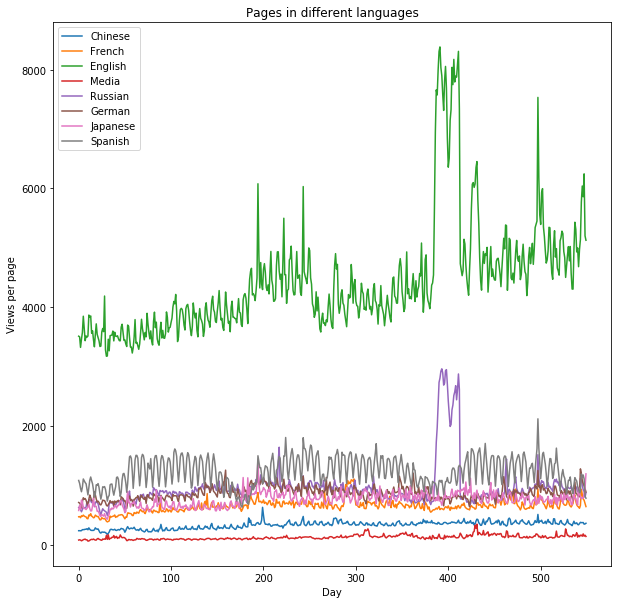

In [7]:
days = [r for r in range(sums["en"].shape[0])]

fig = plt.figure(1, figsize=[10, 10])
plt.ylabel("Views per page")
plt.xlabel("Day")
plt.title("Pages in different languages")
labels={"en": "English", "ja": "Japanese", "de": "German", "na": "Media", "fr": "French", "zh": "Chinese", "ru": "Russian", "es": "Spanish"}

for key in sums:
    plt.plot(days, sums[key], label = labels[key])
    
plt.legend()
plt.show()

Let's plot each language separately in order to analyze better each structure. We'll also plot a magnitude of the Fast Fourier Transform (FFT)to show us the strongest frequencies in the periodic signal

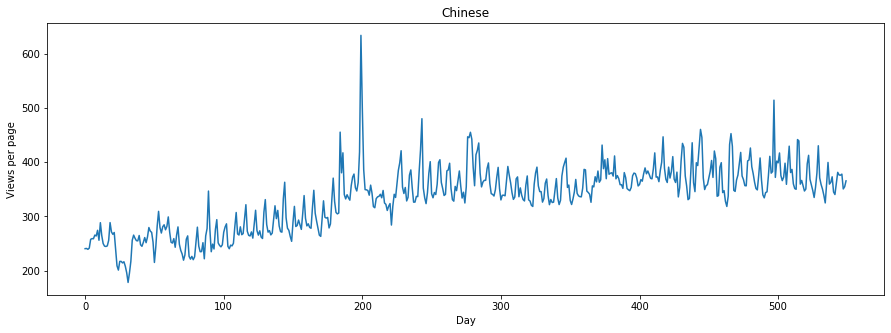

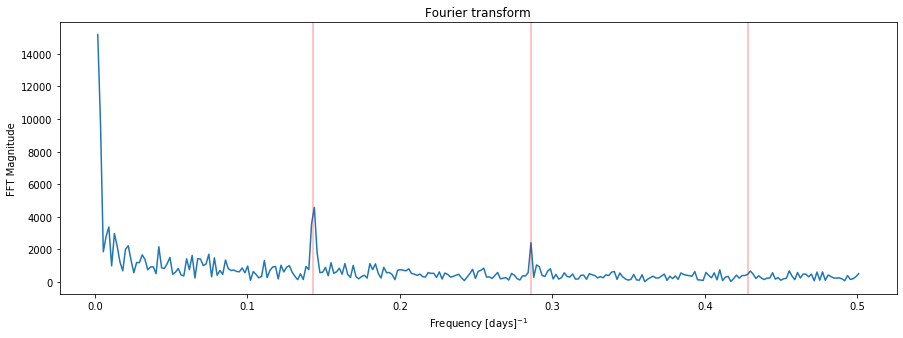

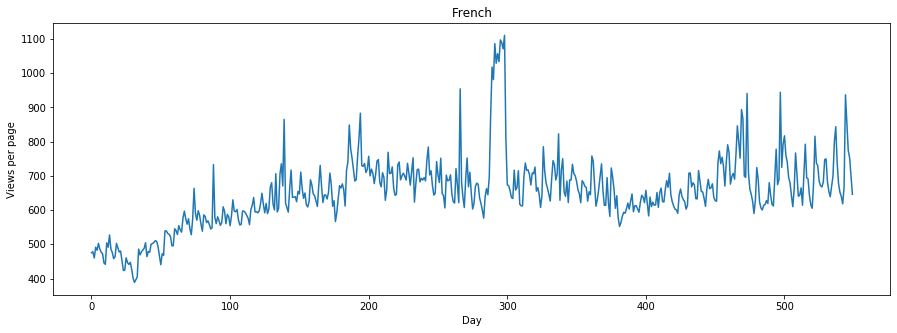

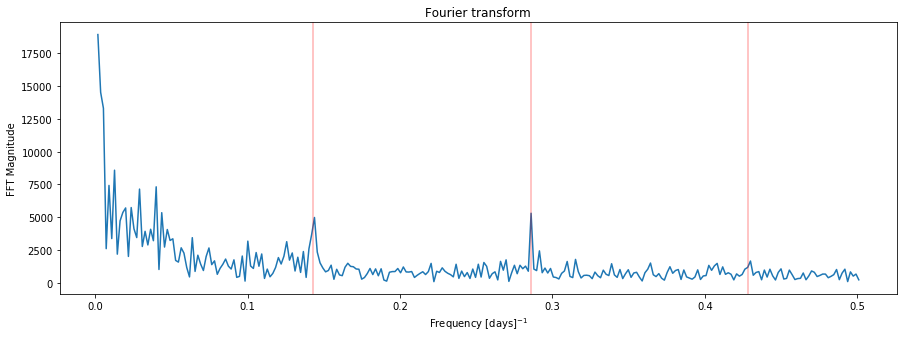

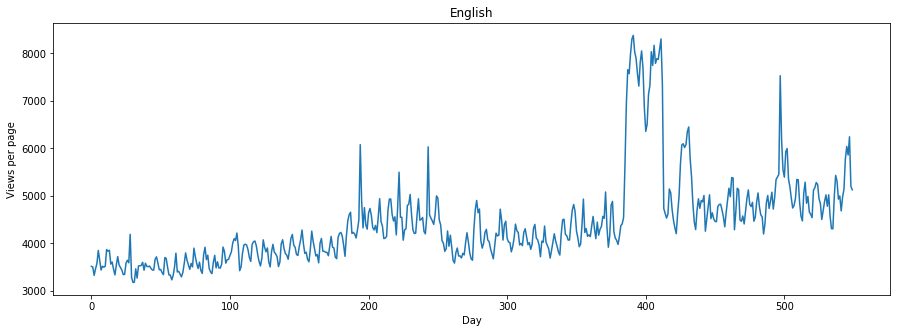

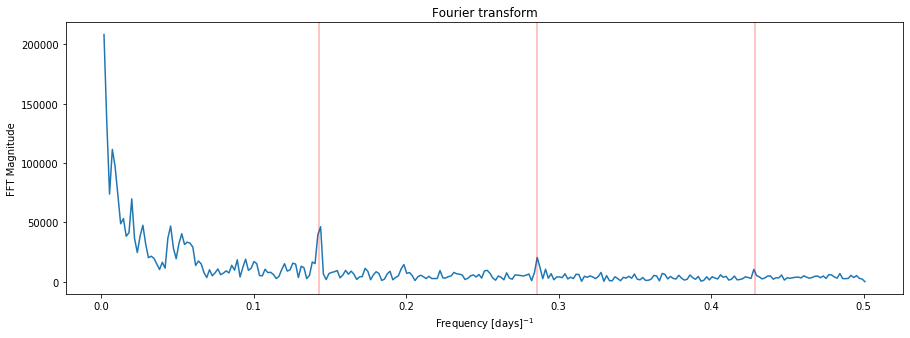

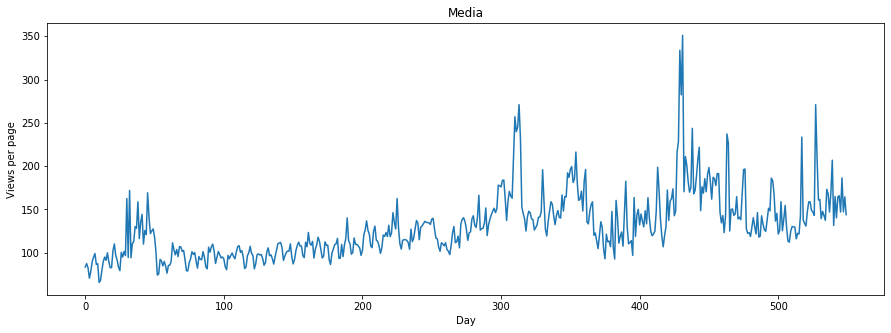

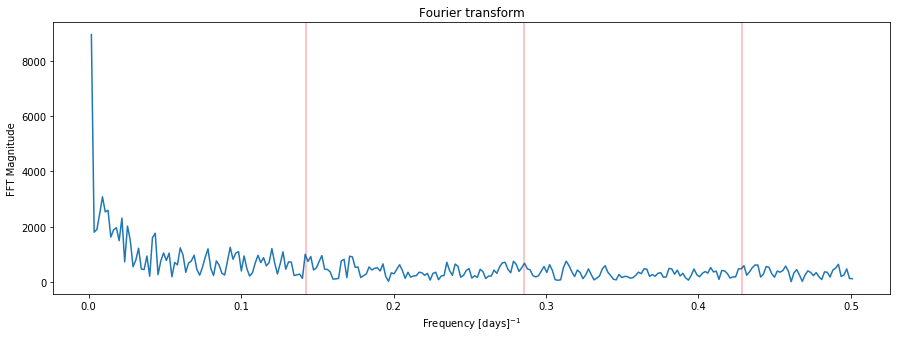

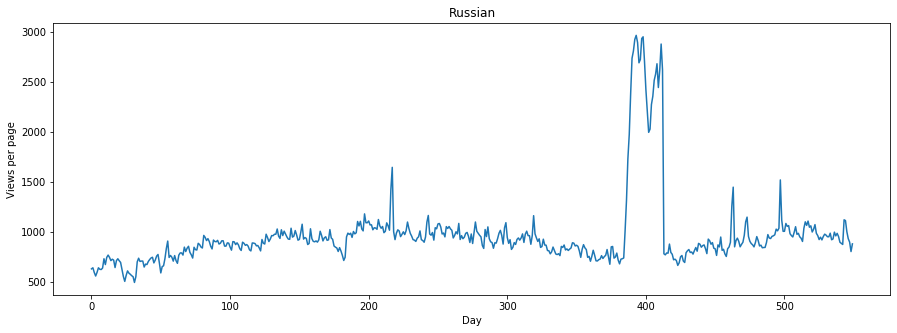

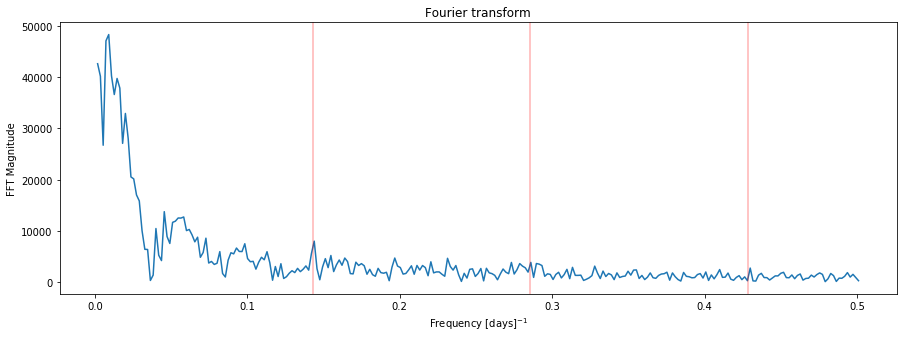

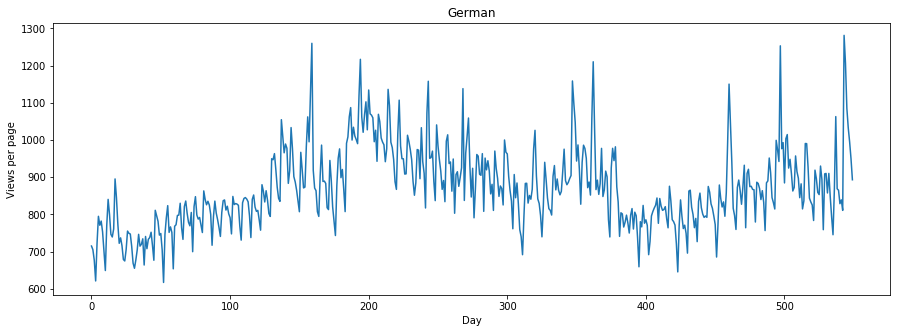

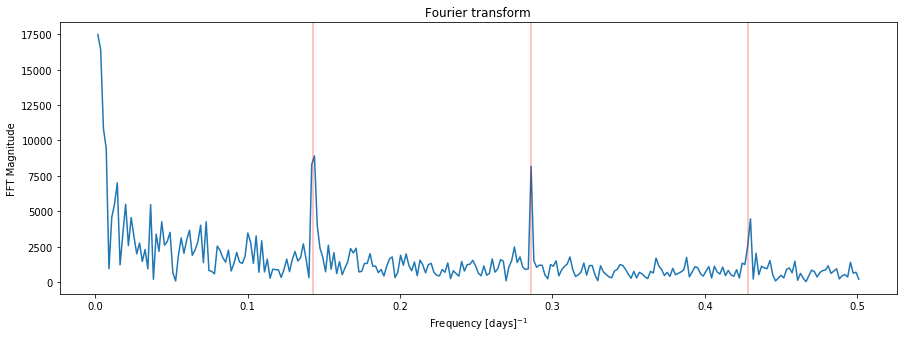

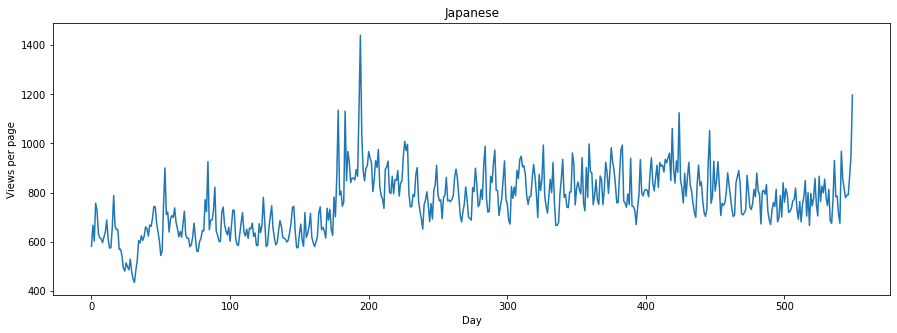

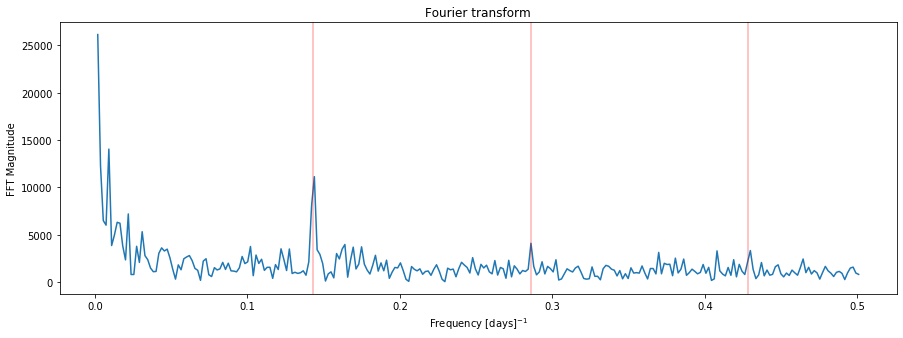

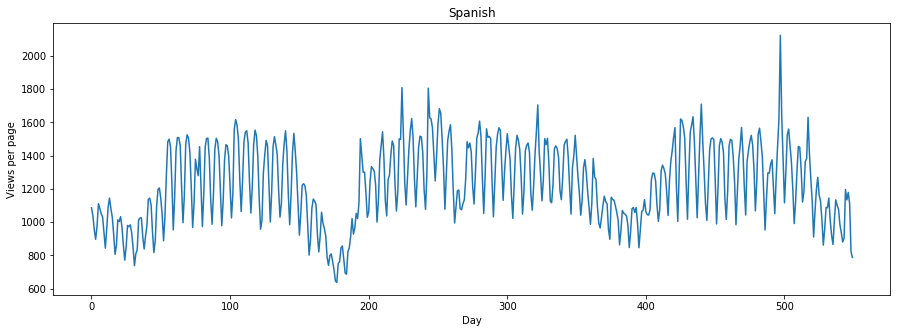

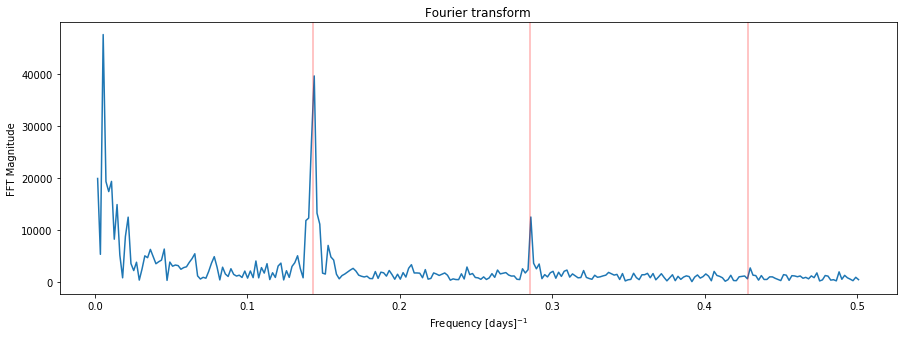

In [8]:
def plot_with_fft(key):
    fig = plt.figure(1, figsize=[15, 5])
    plt.ylabel("Views per page")
    plt.xlabel("Day")
    plt.title(labels[key])
    plt.plot(days, sums[key], label = labels[key])
    
    fig = plt.figure(2, figsize=[15, 5])
    # we plot the ftt freq on the x axis
    # and the magnitude of the vector (how big is it) on the y axis
    fft_complex = fft(sums[key])
    # magnitude is sqrt(a*a + b*b), a is real(x) while b is imaginary(x)
    fft_mag = [np.sqrt(np.real(x)**2 + np.imag(x)**2) for x in fft_complex]
    # norm values of days
    fft_xvals = [day / days[-1] for day in days]
    npts = len(fft_xvals) // 2 + 1
    # analyzing half of the dataset to have a zoomed view
    # also the whole fourier series is specular
    fft_mag = fft_mag[:npts]
    fft_xvals = fft_xvals[:npts]
    
    plt.ylabel("FFT Magnitude")
    plt.xlabel(r"Frequency [days]$^{-1}$")
    plt.title("Fourier transform")
    plt.plot(fft_xvals[1:], fft_mag[1:], label = labels[key])
    # Draw lines at 1, 1/2 and 1/3 week periods
    plt.axvline(x=1./7, color="red", alpha=0.3)
    plt.axvline(x=2./7, color="red", alpha=0.3)
    plt.axvline(x=3./7, color="red", alpha=0.3)
    
    plt.show()
    
for key in sums:
    plot_with_fft(key)

let's plot some individual page views

In [9]:
def plot_entry(key, idx):
    data = lang_sets[key].iloc[idx, 1:]
    fig = plt.figure(1, figsize=(10, 5))
    plt.plot(days, data)
    plt.xlabel("day")
    plt.ylabel("views")
    plt.title(train.iloc[lang_sets[key].index[idx], 0])
    
    plt.show()

We can see from the individual data analyzed down here that the views for each page are not following a constant trend but are jumping when something occours, like for the 2016 shooting at the OG

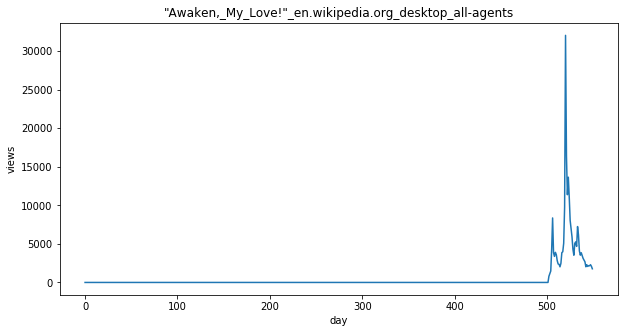

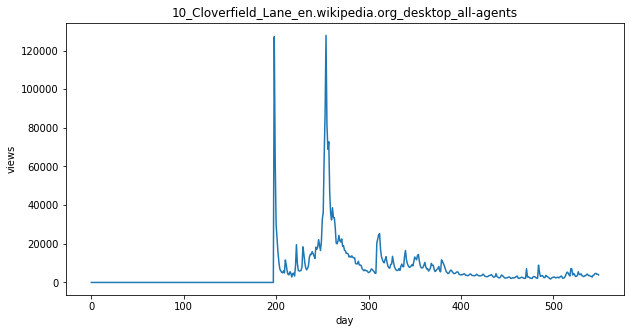

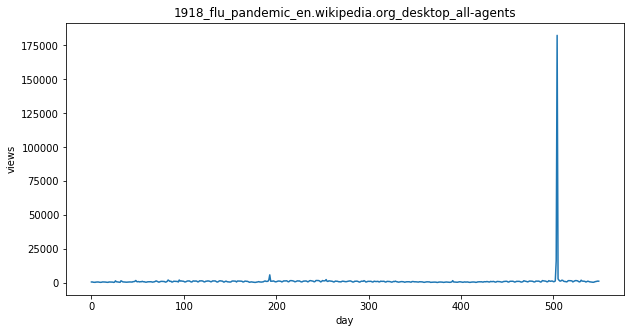

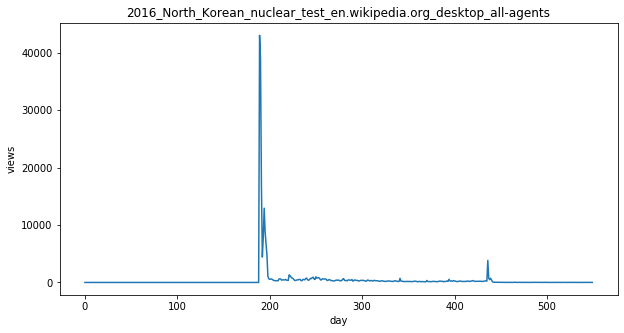

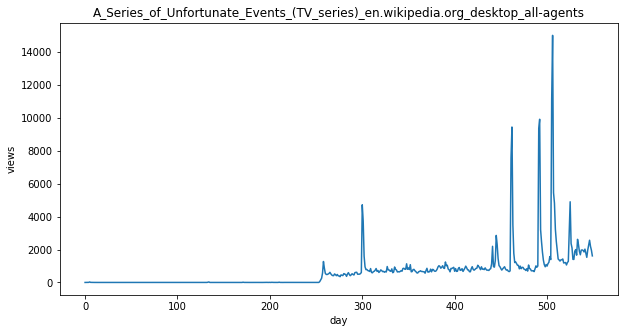

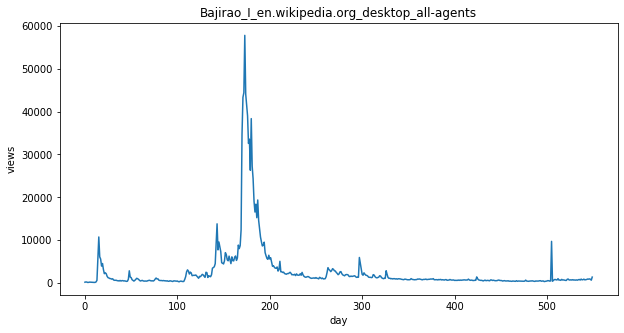

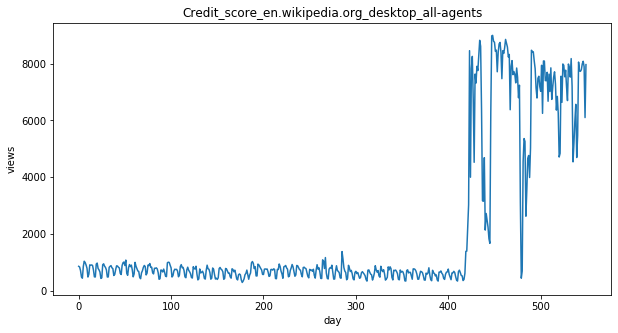

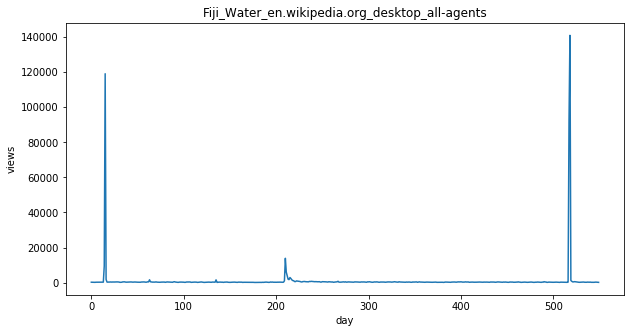

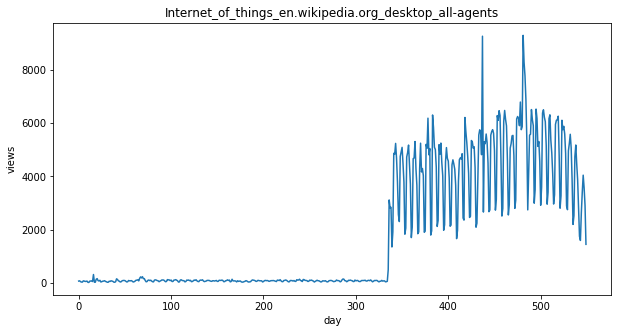

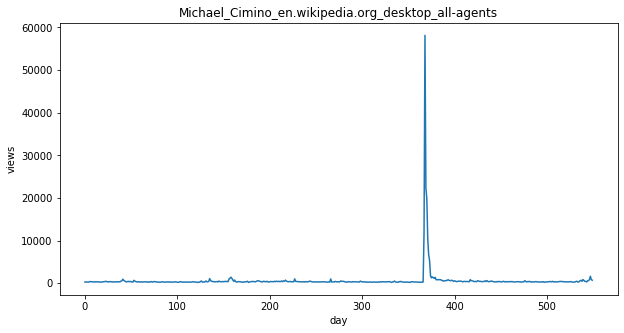

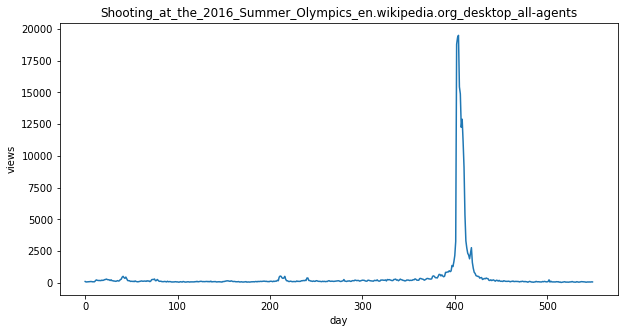

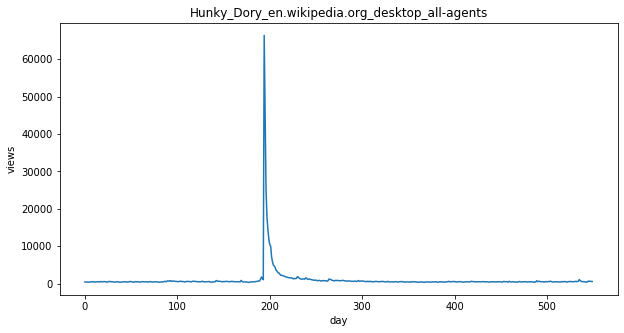

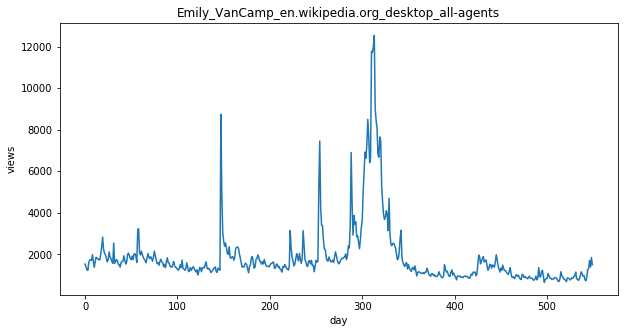

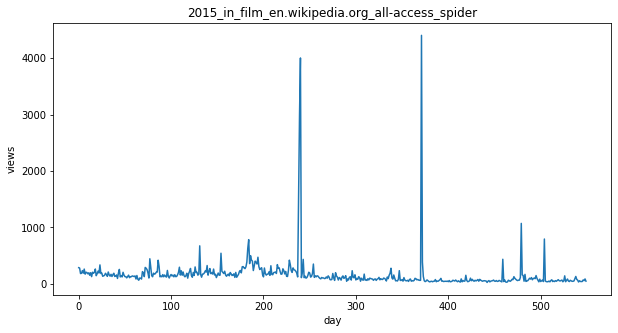

In [10]:
idx = [1, 5, 10, 50, 100, 250, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000]
for i in idx:
    plot_entry("en", i)

In [11]:
# Show pages with the biggest view count
npages = 5
top_pages = {}
for key in lang_sets:
    print(key)
    sum_set = pd.DataFrame(lang_sets[key]["Page"])
    sum_set["total"] =lang_sets[key].sum(axis=1)
    sum_set = sum_set.sort_values("total", ascending=False)
    print(sum_set.head(10))
    top_pages[key] = sum_set.index[0]
    print("\n\n")

zh
                                                     Page      total
28727   Wikipedia:首页_zh.wikipedia.org_all-access_all-a...  123694312
61350    Wikipedia:首页_zh.wikipedia.org_desktop_all-agents   66435641
105844  Wikipedia:首页_zh.wikipedia.org_mobile-web_all-a...   50887429
28728   Special:搜索_zh.wikipedia.org_all-access_all-agents   48678124
61351      Special:搜索_zh.wikipedia.org_desktop_all-agents   48203843
28089   Running_Man_zh.wikipedia.org_all-access_all-ag...   11485845
30960   Special:链接搜索_zh.wikipedia.org_all-access_all-a...   10320403
63510    Special:链接搜索_zh.wikipedia.org_desktop_all-agents   10320336
60711     Running_Man_zh.wikipedia.org_desktop_all-agents    7968443
30446    瑯琊榜_(電視劇)_zh.wikipedia.org_all-access_all-agents    5891589



fr
                                                     Page      total
27330   Wikipédia:Accueil_principal_fr.wikipedia.org_a...  868480667
55104   Wikipédia:Accueil_principal_fr.wikipedia.org_m...  611302821
7344    Wikipédia:Accueil

/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 39318 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 39029 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 39318 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 39029 missing from current font.
  font.set_text(s, 0, flags=flags)


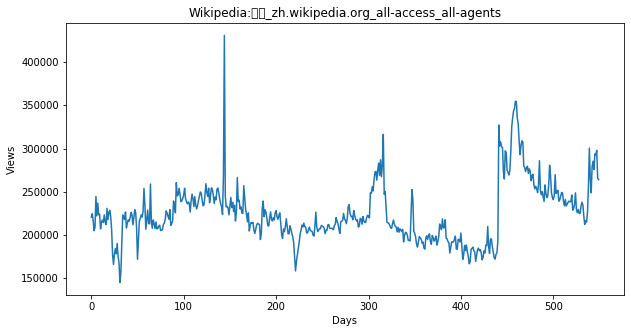

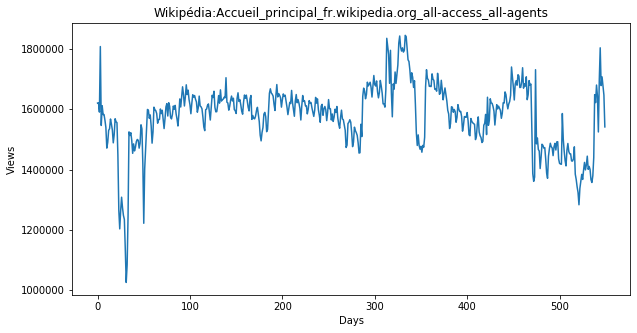

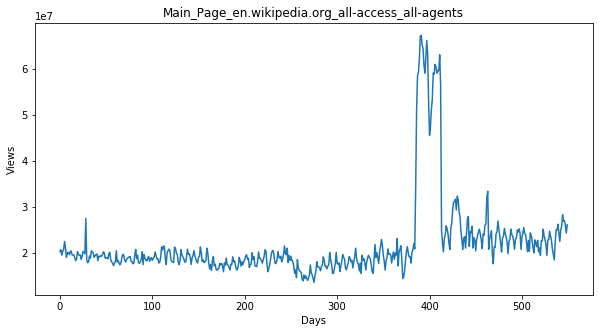

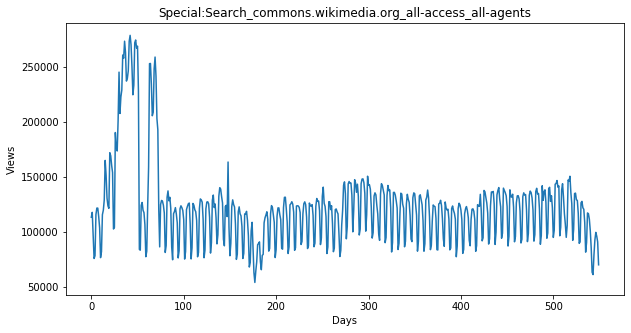

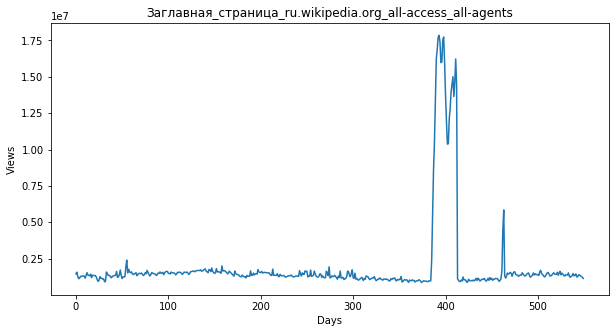

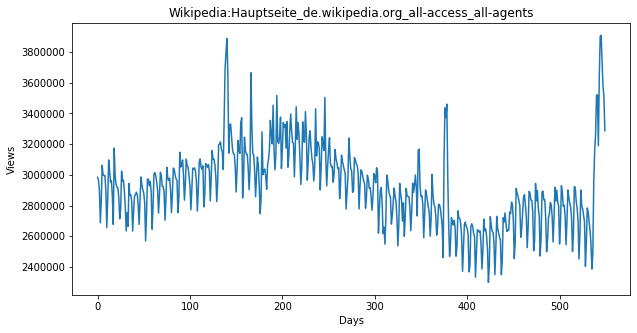

/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12513 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12531 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12506 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/User

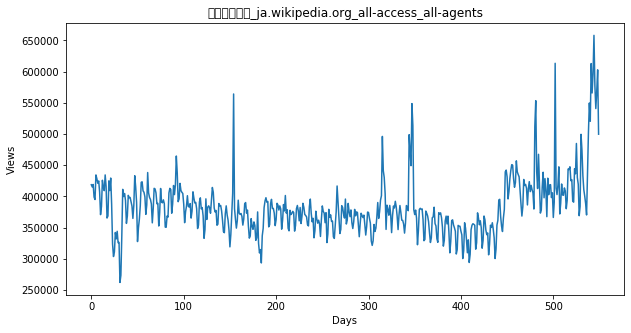

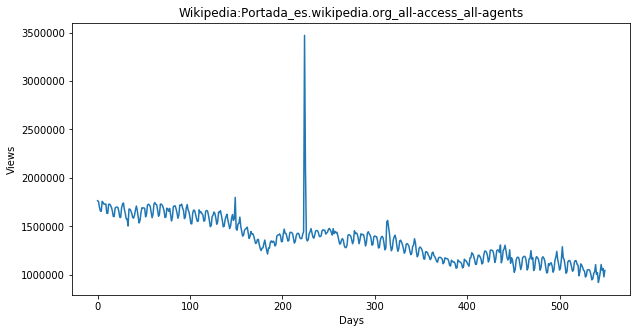

In [12]:
for key in top_pages:
    fig = plt.figure(1, figsize=(10, 5))
    cols = train.columns
    cols = cols[1:-1]
    data = train.loc[top_pages[key], cols]
    plt.plot(days, data)
    plt.xlabel("Days")
    plt.ylabel("Views")
    plt.title(train.loc[top_pages[key], "Page"])
    plt.show()

The big difference between the aggregated data of the views and the individual suggests that the dataset is perhaps not very representative of the traffic to Wikipedia

/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 39318 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 39029 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 39318 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 39029 missing from current font.
  font.set_text(s, 0, flags=flags)


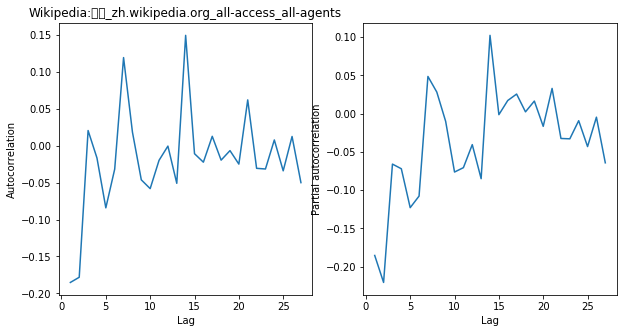

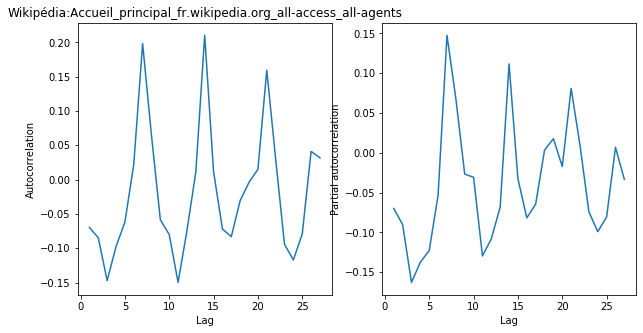

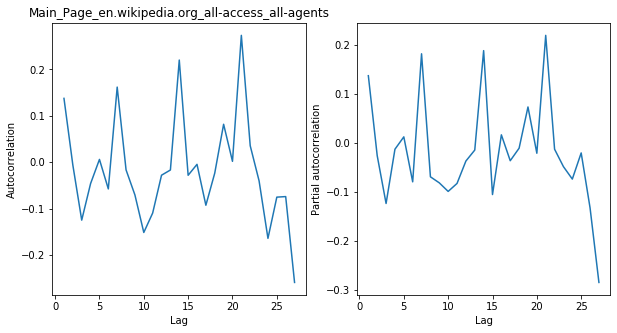

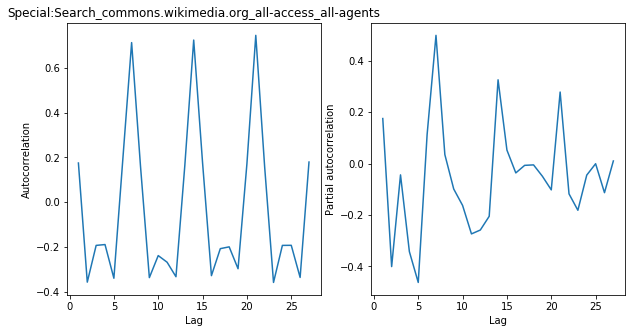

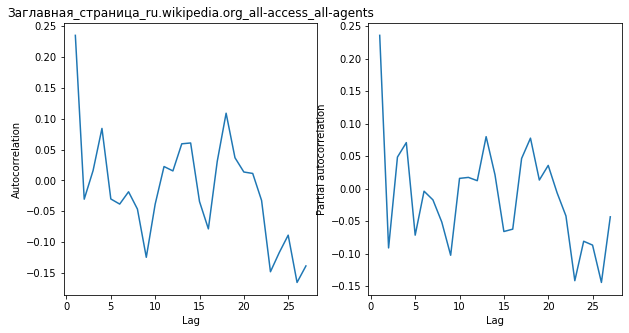

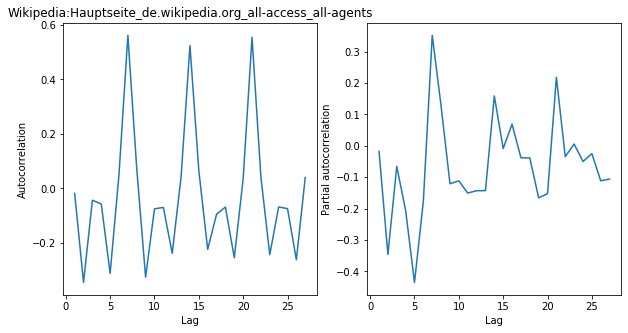

/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12513 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12531 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12506 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/User

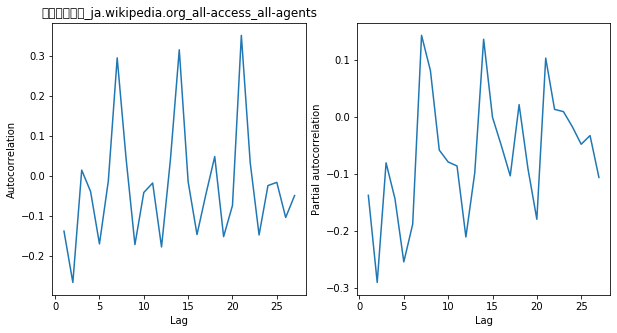

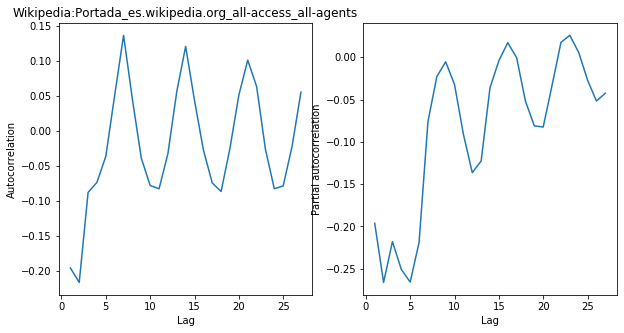

In [13]:
# autocorrelation test
for key in top_pages:
    fig = plt.figure(1, figsize=[10, 5])
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    cols = train.columns[1:-1]
    data = np.array(train.loc[top_pages[key], cols])
    data_diff = [data[i] - data[i-1] for i in range(1, len(data))]
    autocorr = acf(data_diff)
    pac = pacf(data_diff)
    
    x = [x for x in range(len(pac))]
    ax1.plot(x[1:], autocorr[1:])
    
    ax1.set_xlabel("Lag")
    ax1.set_ylabel("Autocorrelation")
    ax1.set_title(train.loc[top_pages[key], "Page"])
    
    ax2.plot(x[1:], pac[1:])
    ax2.set_xlabel("Lag")
    ax2.set_ylabel("Partial autocorrelation")
    plt.show()

There is a strong autocorrelations every 7 days due to weekly effects, in the partial autocorrelations the first week seems the stronger one

/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 39318 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 39029 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 39318 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 39029 missing from current font.
  font.set_text(s, 0, flags=flags)


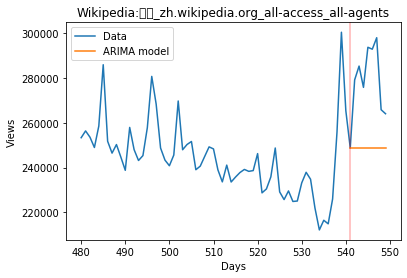

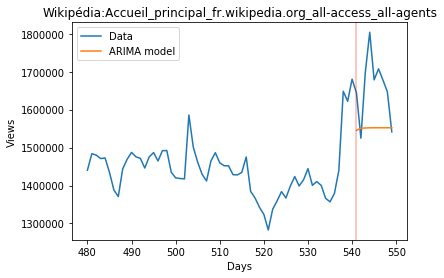

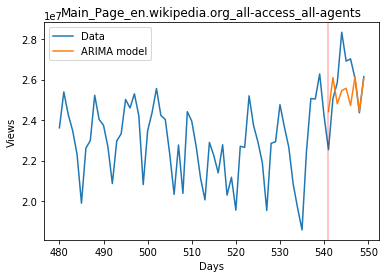

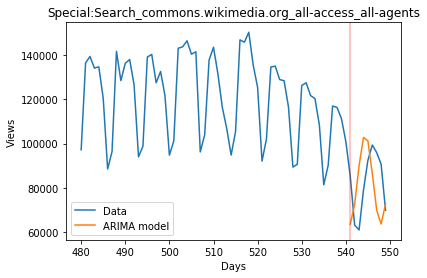

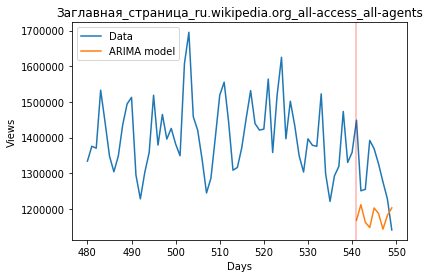

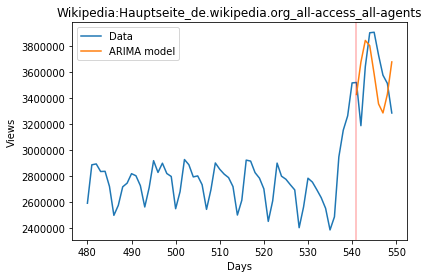

/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12513 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12531 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12506 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/User

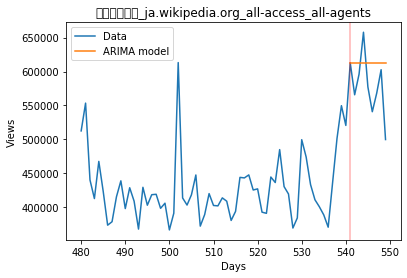

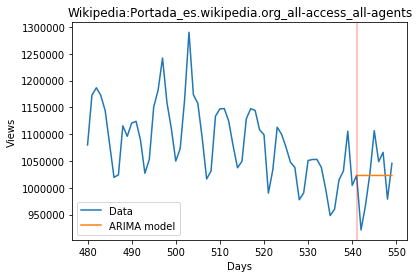

In [77]:
num_forecast = 10
cols = train.columns[1:-1]
train_cols = train.columns[1:len(train.columns)-num_forecast]
test_cols = train.columns[len(train.columns)-num_forecast:-1]

for key in top_pages:
    data = np.array(train.loc[top_pages[key], cols], "f")
    train_data = np.array(train.loc[top_pages[key], train_cols], "f")
    test_data = np.array(train.loc[top_pages[key], test_cols], "f")
    result = None
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        try:
            arima = ARIMA(train_data, order=(2, 1, 4))
            result = arima.fit()
        except:
            try:
                arima = ARIMA(train_data, order=(2, 1, 2))
                result = arima.fit()
            except:
                print(train_data.loc[top_pages[key], "Page"])
                print("\tARIMA failed")
    # test the model with new and unseen data 
    test_arima = ARIMA(test_data, order=(2, 1, 2))
    test_res = test_arima.smooth(result.params)
    #new_result = result.append(test_data, refit=False)
    pred = test_res.forecast(len(test_cols))
    #pred = result.predict(2, 599, typ='levels')
    x = [i for i in range(len(data))]
    x_pred = [i for i in range(train_data.shape[0], train_data.shape[0] + num_forecast - 1)]
    i=0
    
    start_plot_index = len(cols) - num_forecast - 60
    
    # plot actual data
    plt.plot(x[start_plot_index:], data[start_plot_index:], label="Data")
    # plot prediction
    plt.plot(x_pred[:], pred[:], label="ARIMA model")
    plt.axvline(x=train_data.shape[0], color="red", alpha=0.3)
    plt.title(train.loc[top_pages[key], "Page"])
    plt.xlabel("Days")
    plt.ylabel("Views")
    plt.legend()
    plt.show()